# Filter per kernel, compute spatial covariance and plot it using UMAP along time

In [1]:
import mne
from mne.filter import construct_iir_filter

import pyxdf
import numpy as np


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from pyriemann.utils.mean import mean_riemann
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import _add_alpha

import matplotlib.pyplot as plt   
import cv2

from autoreject import AutoReject

In [2]:
kernels = np.load("C:\\Users\\ludov\\Documents\\repos\\MIonline\\classification\\pipeline\\new_kernels_session_4.npy", allow_pickle=True)
k_shape = kernels.shape
if len(k_shape) == 3:
        kernels = kernels.reshape(k_shape[0]*k_shape[1], -1)
# kernels = kernels[:4]
# Load data
fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\2204\\imagerymove.xdf'
streams, header = pyxdf.load_xdf(fname)
for idx, stream in enumerate(streams):
        if stream['info']['type'][0] == 'EEG':
                eeg_stream = idx
        elif stream['info']['name'][0] == 'MotorImageryMarkers':
                marker_stream = idx

data = streams[eeg_stream]["time_series"].T
#transformation from uV to V
data[:] *= 1e-6
# Average re-referencing
ref_data = data.mean(0, keepdims=True)
data -= ref_data
data = data.astype(np.float64)
# Retrieve the number of channels
ch_count = int(streams[eeg_stream]['info']['channel_count'][0])
# Retrieve the channel names
ch_names = [streams[eeg_stream]['info']['desc'][0]['channels'][0]['channel'][ch_nb]['label'][0] for ch_nb in range(ch_count)]

# electrode selection
# list_elect = ["FC1", "Fz", "FC2", "C3", "Cz", "C4", "CP1", "Pz", "CP2"]= [8,4,9,12,13,14,18,24,19]
idx_ch = [8,4,9,12,13,14,18,24,19]
ch_names = np.array(ch_names)[idx_ch]
ch_count = len(ch_names)
data = data[idx_ch,:]

assert data.shape[0] == ch_count  # 8 channels
sfreq = float(streams[eeg_stream]["info"]["nominal_srate"][0])
info = mne.create_info(list(ch_names), sfreq, ['eeg'] * ch_count )
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=9, n_times=248650
    Range : 0 ... 248649 =      0.000 ...   994.596 secs
Ready.


### Load markers

In [7]:

# get difference between EEG onset and onset of Triggers
eeg_onset = streams[eeg_stream]["time_stamps"][0] 
trigger_timestamps = streams[marker_stream]["time_stamps"][:60] - eeg_onset

# get names of triggers (it's a nested list in the xdf file)    
# turn nested list into "normal" one dimensional list
trigger_descriptions = np.array(streams[marker_stream]["time_series"][:60]).astype(int).ravel()

# save trigger descriptions & their onsets as annotations for our Raw object
triggers_annot = mne.Annotations(onset = trigger_timestamps, duration = 4., description = trigger_descriptions)
# Add trigger annotations to the Raw object that's already containing the EEG data
raw = raw.set_annotations(triggers_annot)

### Filter

In [8]:
standard_1020 = mne.channels.make_standard_montage("standard_1020")
raw = raw.set_montage(standard_1020)

# SOS filtering
low = 5
high = 40
iir_params = dict(order=2, ftype='butter', output='sos')  
iir_params = construct_iir_filter(iir_params, f_pass= [low,high], sfreq=sfreq, btype='bandpass', return_copy=True)
print((2 * len(iir_params['sos']), iir_params['padlen']))
raw = raw.filter(low, high, method='iir', iir_params=iir_params)


IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 5.00, 40.00 Hz: -6.02, -6.02 dB

(4, 69)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 40 Hz


## Extend signal by convolution with kernels

def convo_per_channel(data, kernel, mode='same'):
    """Convolution of EEG data with a kernel, channel by channel"""
    conv_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        conv_data[i] = np.convolve(data[i], kernel, mode=mode)
    return conv_data

data = raw.get_data()
data_filtered = []
for kernel in kernels:
    data_convo = convo_per_channel(data, kernel, mode='same')
    data_filtered.extend(data_convo)
data_filtered = np.array(data_filtered)

# Add kernel numbe with underscore sepration after electrode name
ch_names_kernels = [f'{ch}_{i}' for i in range(1, len(kernels)+1) for ch in ch_names]
ch_count = len(ch_names_kernels)
info = mne.create_info(list(ch_names_kernels), sfreq, ['eeg'] * ch_count )
raw = mne.io.RawArray(data_filtered, info)
# raw_filt = raw.set_annotations(triggers_annot)

## Extract covariance on sliding windows

In [66]:
# Define parameters for epoching
event_id = 1  # This is just an example event ID
tmin = 0.0  # Start of each epoch (in seconds)
tmax = 3.0  # End of each epoch (in seconds)
window_length = 3  # Length of each epoch (in seconds)
overlap = 2.8  # Overlap between epochs (in seconds)

# Create events array - this is required for creating epochs
events = mne.make_fixed_length_events(raw, event_id, duration=window_length, overlap=overlap)

# Create an Epochs object
epochs_filt = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True)
total_length = len(epochs_filt)
ar = AutoReject(n_interpolate=np.array([0]), n_jobs=-1)
epochs_filt, logs = ar.fit_transform(epochs_filt, return_log=True)
t = np.arange(0, len(epochs_filt) * 0.2, 0.2)
epochs_filt

Not setting metadata
4959 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4959 events and 751 original time points ...
1 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/4958 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/4958 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=0


  0%|          | Repairing epochs : 0/4958 [00:00<?,       ?it/s]

Dropped 411 epochs: 0, 1, 783, 784, 785, 786, 787, 788, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 2117, 2118, 2119, 2120, 2121, 2122, 212

Number of events,4547
Events,1: 4547
Time range,0.000 – 3.000 s
Baseline,off


In [81]:
from pyriemann.estimation import BlockCovariances
sliding_covs = BlockCovariances(
    estimator='lwf', block_size=len(ch_names)
).transform(epochs_filt.get_data())

C:\Users\ludov\AppData\Local\Temp\ipykernel_13596\4080655734.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ).transform(epochs_filt.get_data())


[Text(0.5, 0, 'PGA, 1st axis'), Text(0, 0.5, 'PGA, 2nd axis')]

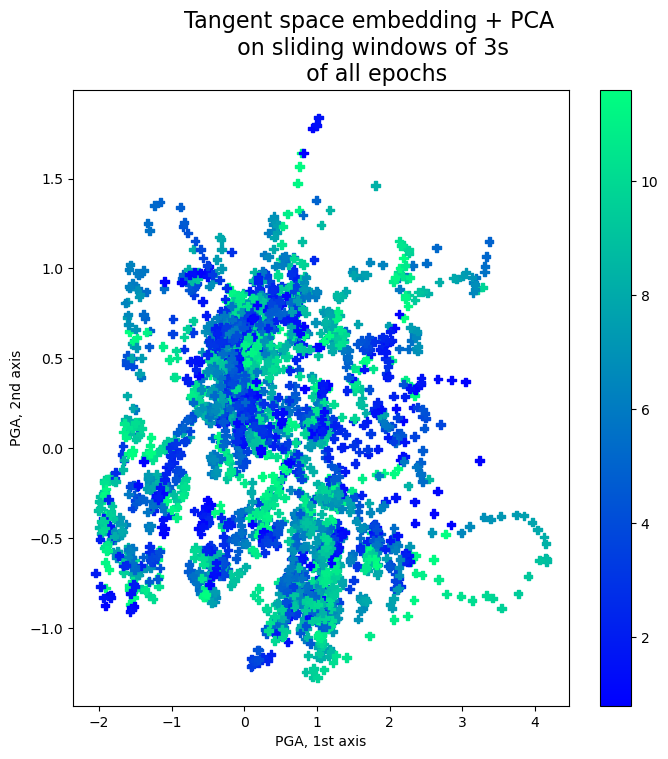

In [95]:
interval_nb = 18
cmap = plt.cm.winter
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(f'Tangent space embedding + PCA \n on sliding windows of 3s \n of all epochs', fontsize=16)
pga = make_pipeline(
    TangentSpace(metric="riemann", tsupdate=False),
    PCA(n_components=2)
)

ts_train = pga.fit_transform(sliding_covs[:, :,:])

for interval_nb in range(len(trigger_timestamps)):
    t1, t2 = trigger_timestamps[interval_nb], trigger_timestamps[interval_nb] + 11
   

    sc = ax.scatter(ts_train[int(t1/0.2): int(t2/0.2), 0], ts_train[int(t1/0.2): int(t2/0.2), 1], c=t[int(t1/0.2): int(t2/0.2)], marker='P', cmap=cmap)
    
cbar = plt.colorbar(sc, ax=ax)
ax.set(xlabel='PGA, 1st axis', ylabel='PGA, 2nd axis')

In [83]:
pga = make_pipeline(
    TangentSpace(metric="riemann", tsupdate=False),
    PCA(n_components=2)
)

ts_train = pga.fit_transform(sliding_covs[:, :,:])

In [84]:
n = total_length // len(np.arange(0, 12, 0.2))
t = np.tile(np.arange(0, 12, 0.2), n + 1)
t = t[:total_length]
t =t[np.where(logs.bad_epochs==False)[0]]

[Text(0.5, 0, 'PGA, 1st axis kernel 3'),
 Text(0, 0.5, 'PGA, 2nd axis kernel 3')]

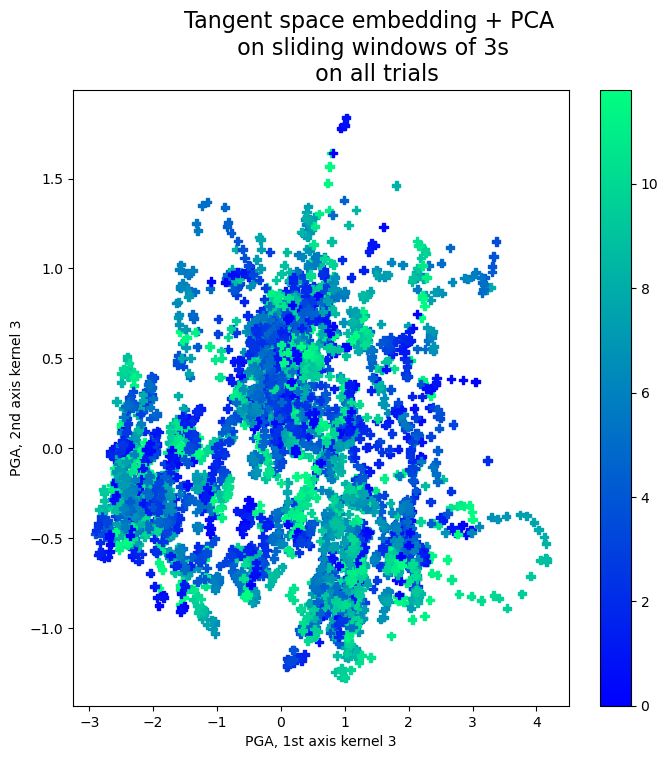

In [85]:
cmap = plt.cm.winter
fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(f'Tangent space embedding + PCA \n on sliding windows of 3s \n on all trials', fontsize=16)

sc = ax.scatter(ts_train[:, 0], ts_train[:, 1], c=t, marker='P', cmap=cmap)
cbar = plt.colorbar(sc, ax=ax)
ax.set(xlabel='PGA, 1st axis kernel 3', ylabel='PGA, 2nd axis kernel 3')


In [105]:
# Define parameters for epoching
event_id = 1  # This is just an example event ID
tmin = 0.0  # Start of each epoch (in seconds)
tmax = 3.0  # End of each epoch (in seconds)
window_length = 3  # Length of each epoch (in seconds)
overlap = 2.8  # Overlap between epochs (in seconds)

# Create events array - this is required for creating epochs
events = mne.make_fixed_length_events(raw, event_id, duration=window_length, overlap=overlap)

# Create an Epochs object
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True)
ar = AutoReject(n_interpolate=np.array([0]))
epochs = ar.fit_transform(epochs)
t = np.arange(0, len(epochs) * 0.2, 0.2)
epochs

Not setting metadata
594 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 594 events and 501 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/594 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/594 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=0


  0%|          | Repairing epochs : 0/594 [00:00<?,       ?it/s]

Dropped 20 epochs: 322, 323, 324, 325, 326, 327, 328, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 458, 459, 460


Number of events,574
Events,1: 574
Time range,0.000 – 2.000 s
Baseline,off


In [106]:
from pyriemann.estimation import BlockCovariances
sliding_covs = BlockCovariances(
    estimator='lwf', block_size=len(ch_names)
).transform(epochs.get_data())

C:\Users\ludov\AppData\Local\Temp\ipykernel_12316\1807145634.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ).transform(epochs.get_data())


In [116]:
pga = make_pipeline(
    TangentSpace(metric="riemann", tsupdate=False),
    PCA(n_components=3)
)

ts_train = pga.fit_transform(sliding_covs)

In [117]:
# Define video parameters
output_video_path = 'scatter_plot_video_autoreject.avi'
fps = 10
frame_size = (800, 600)  # Adjust as per your requirement

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

In [112]:
cmap = plt.cm.viridis
alternating_array = np.concatenate([np.zeros(25), np.ones(25)+8])
t1 = np.tile(alternating_array, len(ts_train) // 100 + 1)[:len(ts_train)//4]
alternating_array = np.concatenate([np.zeros(25), np.ones(25)+2])
t2 = np.tile(alternating_array, len(ts_train) // 100 + 1)[:len(ts_train)//4]
t = np.concatenate([t1, t2])
# Create scatter plot frame by frame
color_index = 0
for i in range(len(ts_train)//2+1, len(ts_train)):
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.suptitle(f'Tangent space embedding + PCA\non sliding windows of 2s\n 5-40Hz filtered \n \n t = {round(i*0.2 - 60,1)}s', fontsize=16)
    
    
    # Scatter plot previous points with their original colors
    ax.scatter(ts_train[len(ts_train)//2:i, 0], ts_train[len(ts_train)//2:i, 1], c=t[:i-len(ts_train)//2], cmap=cmap, marker='P')
    ax.set_xlim(-1.2,2.7)
    ax.set_ylim(-0.8,1)
    
    # cbar = plt.colorbar(sc, ax=ax)
    ax.set(xlabel='PGA, 1st axis kernel 3', ylabel='PGA, 2nd axis kernel 3')

    # Save plot as image
    plt.savefig('temp_plot.png')
    plt.close()
    
    # Read saved image and write it to video
    frame = cv2.imread('temp_plot.png')
    frame = cv2.resize(frame, frame_size)
    out.write(frame)

# Release video writer
out.release()

[Text(0.5, 0, 'PGA, 1st axis kernel 3'),
 Text(0, 0.5, 'PGA, 2nd axis kernel 3')]

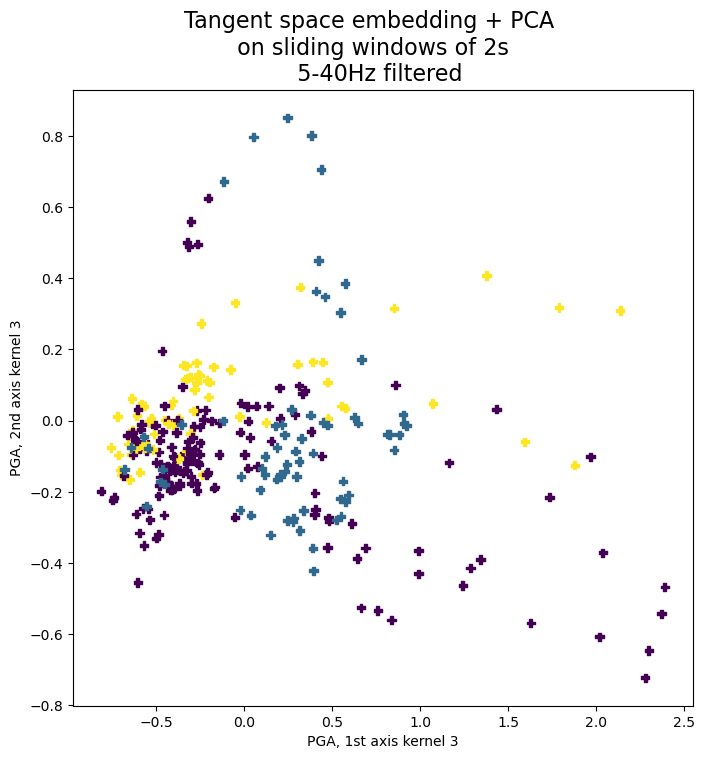

In [118]:
cmap = plt.cm.viridis
alternating_array = np.concatenate([np.zeros(25), np.ones(25)+8])
t1 = np.tile(alternating_array, len(ts_train) // 100 + 1)[:len(ts_train)//4]
alternating_array = np.concatenate([np.zeros(25), np.ones(25)+2])
t2 = np.tile(alternating_array, len(ts_train) // 100 + 1)[:len(ts_train)//4+1]
t = np.concatenate([t1, t2])

fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(f'Tangent space embedding + PCA \n on sliding windows of 2s \n  5-40Hz filtered', fontsize=16)

sc = ax.scatter(ts_train[len(ts_train)//2: len(ts_train), 0], ts_train[len(ts_train)//2: len(ts_train), 1], c=t, marker='P', cmap=cmap)
# cbar = plt.colorbar(sc, ax=ax)
ax.set(xlabel='PGA, 1st axis kernel 3', ylabel='PGA, 2nd axis kernel 3')


[Text(0.5, 0, 'PGA, 1st axis kernel 3'),
 Text(0, 0.5, 'PGA, 2nd axis kernel 3')]

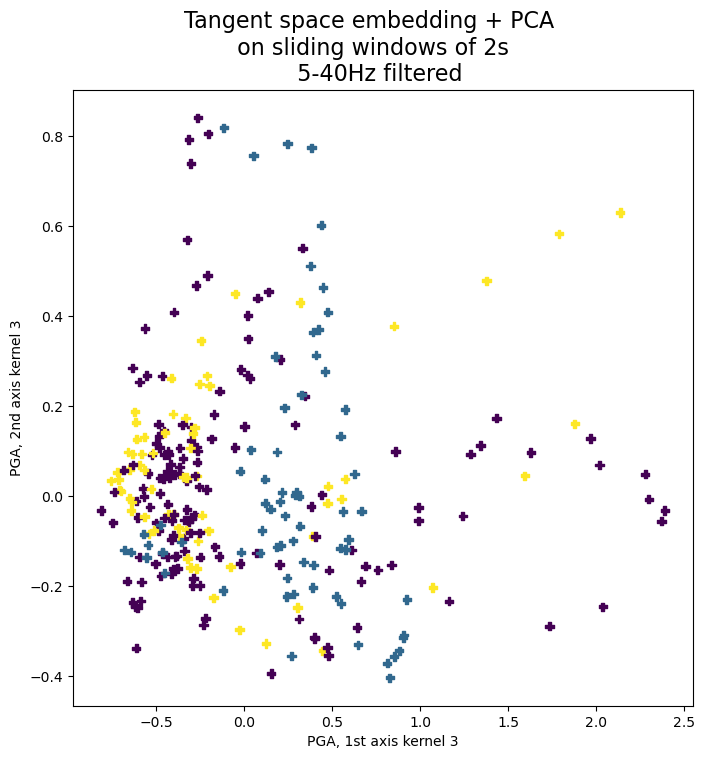

In [121]:
cmap = plt.cm.viridis
alternating_array = np.concatenate([np.zeros(25), np.ones(25)+8])
t1 = np.tile(alternating_array, len(ts_train) // 100 + 1)[:len(ts_train)//4]
alternating_array = np.concatenate([np.zeros(25), np.ones(25)+2])
t2 = np.tile(alternating_array, len(ts_train) // 100 + 1)[:len(ts_train)//4+1]
t = np.concatenate([t1, t2])

fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(f'Tangent space embedding + PCA \n on sliding windows of 2s \n  5-40Hz filtered', fontsize=16)

sc = ax.scatter(ts_train[len(ts_train)//2: len(ts_train), 0], ts_train[len(ts_train)//2: len(ts_train), 2], c=t, marker='P', cmap=cmap)
# cbar = plt.colorbar(sc, ax=ax)
ax.set(xlabel='PGA, 1st axis', ylabel='PGA, 2nd axis')


[Text(0.5, 0, 'PGA, 1st axis'), Text(0, 0.5, 'PGA, 2nd axis')]

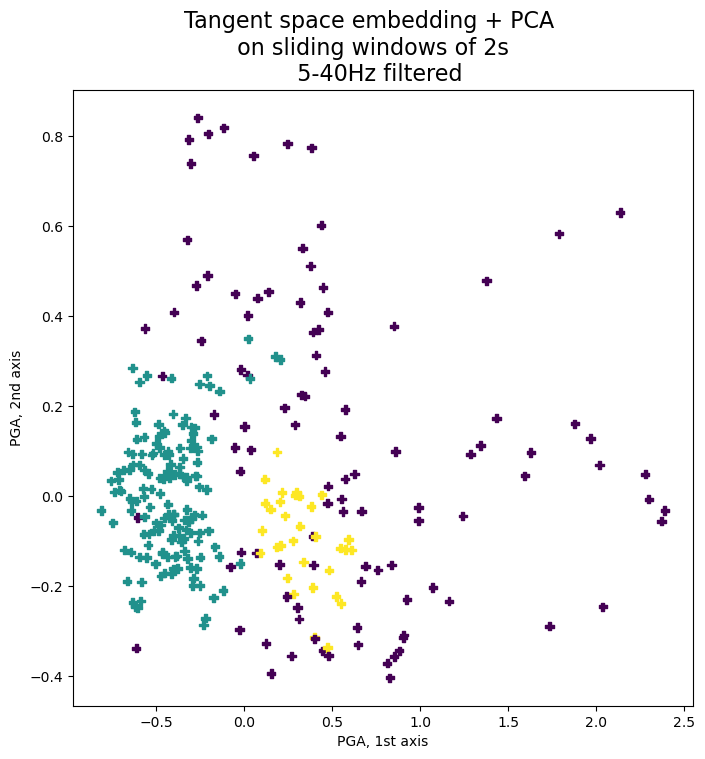

In [139]:
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN

# kmeans = KMeans(n_clusters=4, random_state=0)
# kmeans.fit(ts_train[len(ts_train)//2: len(ts_train)])
# y_pred = kmeans.predict(ts_train[len(ts_train)//2: len(ts_train)])

# dbscan = DBSCAN(eps=0.15, min_samples=8)
# y_pred = dbscan.fit_predict(ts_train[len(ts_train)//2: len(ts_train)])

dbscan = HDBSCAN(min_cluster_size=10, min_samples=8, cluster_selection_epsilon=0.15)
y_pred = dbscan.fit_predict(ts_train[len(ts_train)//2: len(ts_train)])

fig, ax = plt.subplots(figsize=(8, 8))
fig.suptitle(f'Tangent space embedding + PCA \n on sliding windows of 2s \n  5-40Hz filtered', fontsize=16)

sc = ax.scatter(ts_train[len(ts_train)//2: len(ts_train), 0], ts_train[len(ts_train)//2: len(ts_train), 2], c=y_pred, marker='P', cmap=cmap)
# cbar = plt.colorbar(sc, ax=ax)
ax.set(xlabel='PGA, 1st axis', ylabel='PGA, 2nd axis')

In [122]:
import umap

fit = umap.UMAP()
%time u = fit.fit_transform(epochs.get_data(copy=True)[:, 5, :])

CPU times: total: 10 s
Wall time: 5.31 s


ValueError: 'c' argument has 287 elements, which is inconsistent with 'x' and 'y' with size 574.

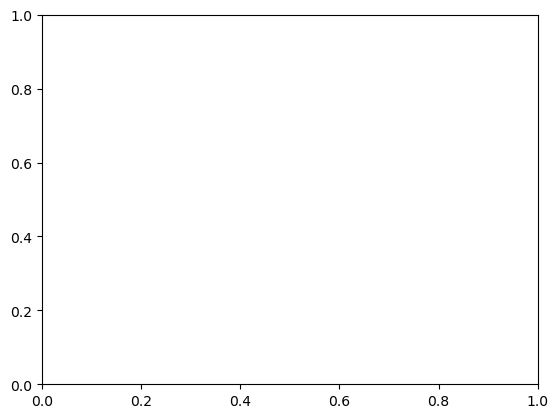

In [123]:
plt.scatter(u[:,0], u[:,1], c=t, cmap='viridis', s=10, alpha=0.5)
plt.colorbar()